In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchsummary import summary

In [2]:
from datetime import datetime

current_datetime = datetime.now()
print(current_datetime)


2024-05-04 18:02:43.399040


### 1. Preprocess the MNIST dataset and read the data

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [6]:
# Load the original MNIST dataset

# Download and load the training data
trainset = datasets.MNIST('./dataset/train', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('./dataset/test', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


# Split the training data into training set and validation set
val_size = int(0.1 * len(trainset))  # 10% for validation set
train_size = len(trainset) - val_size
trainset, valset = random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)


##### out of memory - reduce the training set to 1000 samples

In [8]:
# out of memory - cut the training set to 1000 samples
from torch.utils.data import Subset

# Define the number of samples for debugging
num_samples = 1000

# Download and load the training data
trainset = datasets.MNIST('./dataset/train', download=False, train=True, transform=transform)
trainset = Subset(trainset, range(num_samples))  # Use only the first num_samples samples
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('./dataset/test', download=False, train=False, transform=transform)
testset = Subset(testset, range(num_samples))  # Use only the first num_samples samples
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Split the training data into training set and validation set
val_size = int(0.1 * len(trainset))  # 10% for validation set
train_size = len(trainset) - val_size
trainset, valset = random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

#### Dataset website link:  http://yann.lecun.com/exdb/mnist/

### 2. Define the VGG16 model

In [12]:
# Define the VGG16 model

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [5]:
# Use the pretrained VGG16 model
import torch
from torchvision import models

# Define the VGG16 model
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        # Load a pre-trained version of VGG16
        self.vgg16 = models.vgg16(pretrained=True)
        # Replace the last fully-connected layer
        # Parameters of newly constructed modules have requires_grad=True by default
        num_ftrs = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = torch.nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.vgg16(x)
        return x

### 3. Model summary

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = VGG16(num_classes=10).to(device)
summary(vgg16, (3, 224, 224))



d:\CODING\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\CODING\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### 4. Train and visulization of the VGG16 model

Epoch 1/50 | Training loss: 2.1813336849212646 | Validation loss: 1.657617211341858 | Training accuracy: 20.555555555555557% | Validation accuracy: 55.0%
Epoch 2/50 | Training loss: 1.1189598619937897 | Validation loss: 0.3882763087749481 | Training accuracy: 63.22222222222222% | Validation accuracy: 84.0%
Epoch 3/50 | Training loss: 0.3657622889926036 | Validation loss: 0.2747221738100052 | Training accuracy: 88.33333333333333% | Validation accuracy: 92.0%
Epoch 4/50 | Training loss: 0.15738082739214102 | Validation loss: 0.10142713598906994 | Training accuracy: 94.44444444444444% | Validation accuracy: 97.0%
EarlyStopping counter: 1 out of 30
Epoch 5/50 | Training loss: 0.08189081996679307 | Validation loss: 0.11710253357887268 | Training accuracy: 97.44444444444444% | Validation accuracy: 96.0%
EarlyStopping counter: 2 out of 30
Epoch 6/50 | Training loss: 0.051984878024086356 | Validation loss: 0.1072836834937334 | Training accuracy: 97.88888888888889% | Validation accuracy: 96.0%


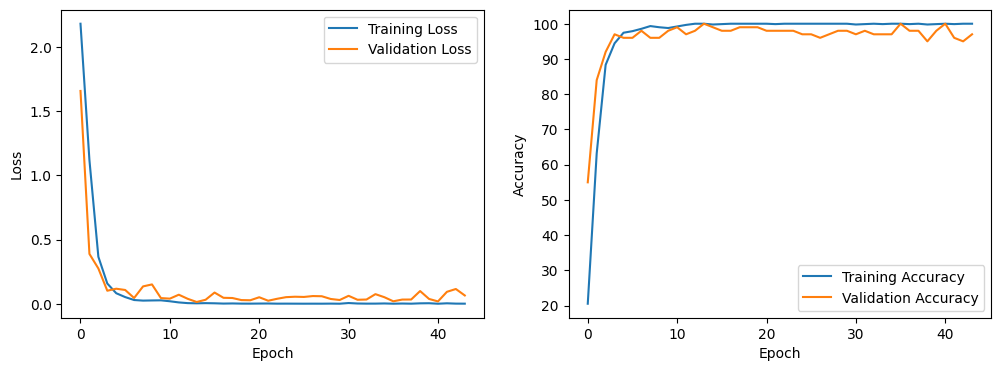

In [10]:
# Initialize the VGG16 model and move it to the GPU if available
vgg16 = VGG16(num_classes=10).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# Initialize lists to hold the losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize the patience and the counter for early stopping
# add early stopping to prevent overfitting during model training
patience = 30
early_stopping_counter = 0

# Initialize the minimum validation loss to a large value
min_val_loss = float('inf')

# Train the model
epochs = 50
for epoch in range(epochs):
    running_loss = 0
    correct_train = 0
    total_train = 0
    vgg16.train()  # Set the model to training mode
    for inputs, labels in trainloader:
        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted_train = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted_train.eq(labels).sum().item()
    else:
        # Save the loss and accuracy for this epoch
        train_losses.append(running_loss/len(trainloader))
        train_accuracies.append(100 * correct_train / total_train)
        
        # Validation
        vgg16.eval()  # Set the model to evaluation mode
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = vgg16(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss /= len(valloader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        

        # Check if the validation loss is the lowest so far
        if val_loss < min_val_loss:
        # If so, save the model and update the minimum validation loss
            torch.save(vgg16.state_dict(), 'best_model_VGG16.pth')
            min_val_loss = val_loss
            early_stopping_counter = 0  # Reset the counter
        else:
        # If not, increment the counter
            early_stopping_counter += 1
            print(f'EarlyStopping counter: {early_stopping_counter} out of {patience}')
            if early_stopping_counter >= patience:
                print('Early stopping')
                break  # Stop the training

        # Print the loss and accuracy for this epoch in one line
        print(f"Epoch {epoch+1}/{epochs} | Training loss: {running_loss/len(trainloader)} | Validation loss: {val_loss} | Training accuracy: {100 * correct_train / total_train}% | Validation accuracy: {val_accuracy}%")

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 5. Calculate the accuracy of the model on the total test set

In [11]:
# calculate the accuracy of the model on the total test set
# Load the best model
vgg16.load_state_dict(torch.load('best_model_VGG16.pth'))

vgg16.eval()  # Set the model to evaluation mode

correct = 0
total = 0

# No need to track gradients for validation, saves memory and computations
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 96 %


### 6. Calculate the accuracy of the model on the total test set for each class


In [12]:
# 得到每一个类别的准确率（共10个类别）

vgg16.load_state_dict(torch.load('best_model_VGG16.pth'))

# Set the model to evaluation mode
vgg16.eval()

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# No need to track gradients for validation, saves memory and computations
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    if class_total[i] != 0:
        print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))
    else:
        print('Accuracy of %5s : N/A' % i)


Accuracy of     0 : 100 %
Accuracy of     1 : 90 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 88 %
Accuracy of     5 : 100 %
Accuracy of     6 : 85 %
Accuracy of     7 : 100 %
Accuracy of     8 : 100 %
Accuracy of     9 : 100 %
